# prefixtune

## libraries

In [2]:
import argparse, os, string, sys
import torch
import sacrebleu
from tqdm import tqdm
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer, default_data_collator, get_linear_schedule_with_warmup
from datasets import load_dataset
from pathlib import Path
from peft import PrefixTuningConfig, get_peft_model,TaskType, PeftModel
from torch.utils.data import DataLoader

## Documentation

In [5]:
def train(self):
        data_loaders = self.get_data(splits=("train", ))
        model = AutoModelForCausalLM.from_pretrained(self.basemodel)

        # You can print the parameters for debugging or understanding the code
        # but make sure you comment it out otherwise it will pollute the output
        # that is produced for dev and test
        #model.print_trainable_parameters()
        prefix_tuning_config = PrefixTuningConfig(
            task_type=TaskType.CAUSAL_LM, inference_mode=False,
            num_virtual_tokens=self.virtualtokens,
            prefix_projection=self.prefixprojection
        )
        model = get_peft_model(model, prefix_tuning_config)

        optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=(len(data_loaders["train"]) * self.epochs),
        )
        model = model.to(device)

        for epoch in range(self.epochs):
            model.train()

            total_loss = 0
            for step, batch in enumerate(tqdm(data_loaders['train'])):
                assert list(batch.keys()) == ['input_ids', 'attention_mask', 'labels']
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                total_loss += loss.detach().float()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            train_epoch_loss = total_loss / len(data_loaders['train'])
            train_ppl = torch.exp(train_epoch_loss)
            print(f"{epoch=}: {train_ppl=} {train_epoch_loss=}")
            if epoch == self.epochs - 1:
                epoch_str = '' # last epoch so do not use epoch number in model filename
            else:
                epoch_str = str(epoch)
            savefile = self.modelfile + epoch_str + self.modelsuffix
            model.save_pretrained(savefile)

## Result 

Our model was able to achieve a dev score of 36.6057 and a small score of 30.5516. The hyperparameters used to obtain this was prefixprojection set to true, epoch set to 1, batchsize set to 16, and virtualtoken set to 5. Furthermore, the parameter no_repeat_ngram_size was set to 5 and max_new_tokens was set to 30 in model.generate under the predict function. 

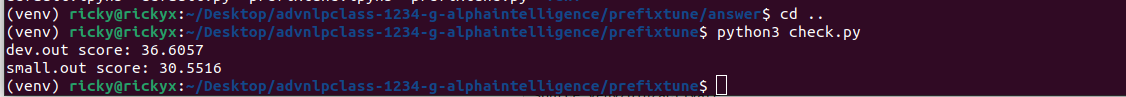

## Analysis

### 1. epochs
We tested various epoch values and found that epoch with a value of 1 gave the best result when no_repeat_ngram_size was set to 5 in model.generate. A epoch value of 5 produced the 2nd best result when no_repeat_ngram_size was set to none. However, epoch 5 gave a low bleu score when the training was done on a csil machine. This might suggest that epoch is dependent on the hardware. Thus, different machines may favor different epoch values. 

### 2. batchsizes 
For batchsize testing, we experimented with different batchsizes on 3 epoch values. We learned that different epochs favored different batchsizes. Batchsize 16 produced the best result for epoch 1, batchsize 32 produced the best result for epoch 3, and batchsize 16 produced the best result for epoch 5.

### 3. virtualtokens

Similarly to how we tested batchsizes, we also experimented with different virtual tokens across three epochs. Virtual token 5 gave the best score for epoch 1, virtual token 8 gave the best score for epoch 3, and virtual token 5 gave the best score for epoch 5. The results suggests that the optimal virtual token value is dependent on the epoch value. 

### 4. no_repeat_ngram_size

Default prediction repeat itself not just by words also by whole sentences. By setting high no_repeat_ngram_size, we can mitigate this problem by preventing the model from repeating the whole sentences.

### 5. Max_new_token

After generating about 20 tokens, the model would starting repeating itself. We prevents this by simply setting Max_new_token to a lower number. In our experiments, setting it to 20 and 30 works similarly. 

## Group work

* kerryz wrote prefixtuning code, tweak predict() hyperparameters, and contributed to writeup30
* rxa13 tried various hyperparameters, attempted to improve predict, and contributed to writeup 
*